In [1]:
from models.dataset import Dataset, DatasetReality
from tools.common import sparse_shuffle

from scipy import sparse
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
warnings.simplefilter('ignore')

In [2]:
def prep_data(Dataset, shuffle_interval=1):
    dataset = Dataset()
    # print('# features: ', len(dataset.features_))
    data = []
    for i in range(len(dataset)):
        print('[%i]' % i, end='\r')
        data.append(dataset[i])
    print('[%i]' % (i+1))
    data = sparse.vstack(data)
    print('Shape', data.shape) 
    # recall can be very high if not shuffle the data, why?
    data = sparse_shuffle(data, interval=shuffle_interval)
    X, y = data[:,:-1], data[:,-1]
    y = y.toarray().flatten()
    return dataset, X, y

In [3]:
dataset, X, y = prep_data(Dataset, shuffle_interval=3)

[92]
Shape (276, 11701)


In [4]:
# higher class weight of 0 will always make it easier in term of precision
# because of imbalance
clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         class_weight={1: 1, 0:0.3},
                         penalty='l1', #'l2' use l1 to learn sparsely
                         C=1.0,
                         max_iter=1000)

interval = 3 #3 #4
ind_test = int(X.shape[0]/interval * 0.9) * interval
print('# train: ', ind_test)
print('# test: ', X.shape[0] - ind_test)
clf.fit(X[:ind_test], y[:ind_test])
# clf.fit(X, y)
y_true = y[ind_test:]
y_prob = clf.predict_proba(X[ind_test:])[:,1]

# train:  246
# test:  30


10 positives out of 30 test examples
Overall accuracy: 0.533333
*Recall(thresh=0.5)/AccuracyOf1: 0.700000
Precision(thresh=0.5): 0.388889
AccuracyOf0(thresh=0.5): 0.450000


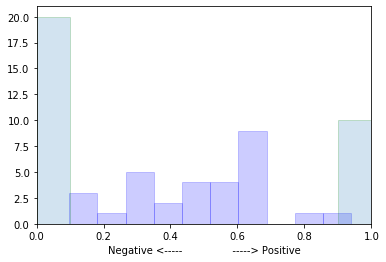

In [5]:
from ana.visual import STAT, ROC, FEAT
STAT(y_true, y_prob)

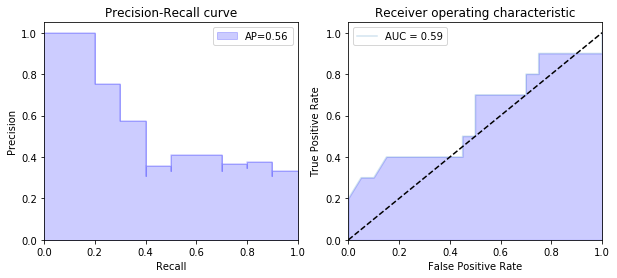

In [6]:
ROC(y_true, y_prob)

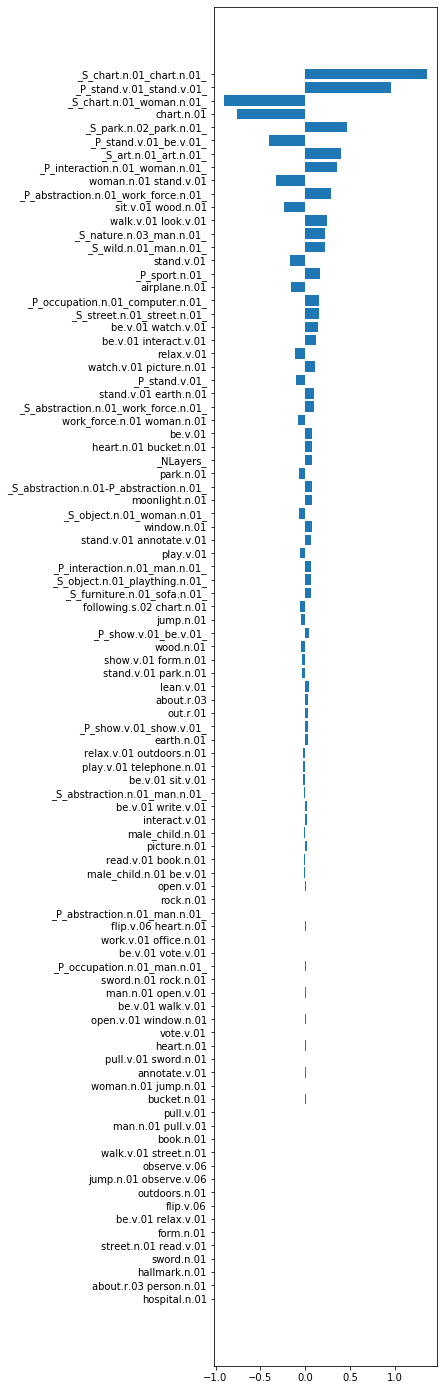

In [7]:
FEAT(dataset, clf)

In [8]:
dataset_r, X_r, y_r = prep_data(DatasetReality, shuffle_interval=2)

[92]
Shape (184, 311)


In [9]:
# higher class weight of 0 will always make it easier in term of precision
# because of imbalance
clf_r = LogisticRegression(# random_state=0,
                           solver='liblinear',
                           class_weight={1: 1, 0:1},
                           penalty='l1', #'l2' use l1 to learn sparsely
                           C=1.0,
                           max_iter=1000)

interval = 2
ind_test = int(X_r.shape[0]/interval * 0.9) * interval
print('# train: ', ind_test)
print('# test: ', X_r.shape[0] - ind_test)
clf_r.fit(X_r[:ind_test], y_r[:ind_test])
# clf.fit(X, y)
y_true = y_r[ind_test:]
y_prob = clf_r.predict_proba(X_r[ind_test:])[:,1]

# train:  164
# test:  20


10 positives out of 20 test examples
Overall accuracy: 0.900000
*Recall(thresh=0.5)/AccuracyOf1: 1.000000
Precision(thresh=0.5): 0.833333
AccuracyOf0(thresh=0.5): 0.800000


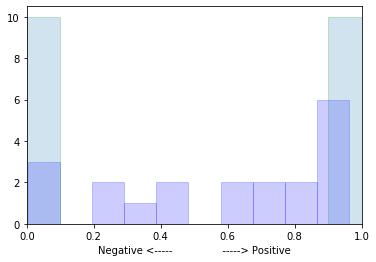

In [10]:
STAT(y_true, y_prob)

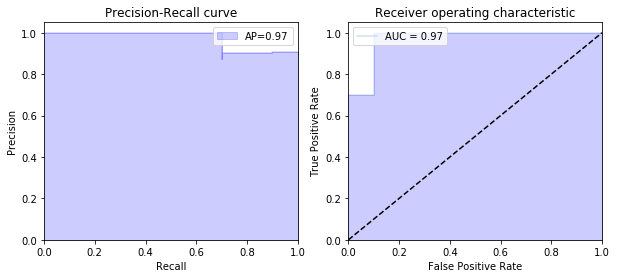

In [11]:
ROC(y_true, y_prob)

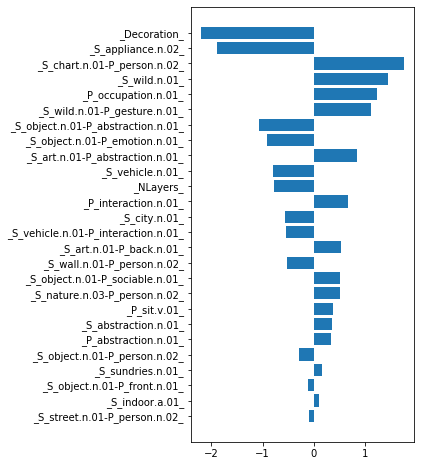

In [12]:
FEAT(dataset_r, clf_r)

wild - gesture ++ (play in the park)

surrounding - object? --
person - interaction? --

if object stuff, interaction is rare?

In [13]:
# todo - unseen keywords

In [14]:
# brutal-force search

In [15]:
def exhaustiveSearch(query_txt, lamb=0.7):
    print('text: %s' % query_txt)
    print('tokens:', dataset.txt_encoder.tokenizer(query_txt))
    probs = []
    for i, layers in enumerate(dataset.all_layers):
        print('[%i]' % i, end='\r')
        X = dataset.encode(sent=query_txt, layers=layers)
        prob_consis = np.squeeze(clf.predict_proba(X.reshape(1,-1)))[1]
        X_r = dataset_r.img_encoder.encode(layers)
        prob_real = np.squeeze(clf_r.predict_proba(X_r.reshape(1,-1)))[1]
        probs.append((i, prob_consis*lamb + prob_real*(1-lamb)))
        
    imax, max_prob = max(probs, key=lambda x: x[1])
    max_layers = dataset.all_layers[imax]
    print('Most consistent layer:', max_layers, 'Prob: %.6f' % max_prob)
    print('Corresponding keywords:', dataset.img_encoder.layer2keyword(max_layers))
    return max_layers

In [16]:
layers = exhaustiveSearch('A man plays in a park.')

text: A man plays in a park.
tokens: ['man.n.01', 'play.v.01', 'park.n.01']
Most consistent layer: ['A2221', 'A311'] Prob: 0.810279
Corresponding keywords: ['outdoor.a.01', 'nature.n.03', 'park.n.02', 'interaction.n.01', 'occupation.n.01']


In [17]:
import glob
import random
def getMaterial(layer):
    l = glob.glob('material/%s*.png' % layer)
    return random.choice(l)

from tools.image_process import stack_svgs
stack_svgs([getMaterial(layer) for layer in layers])

from IPython.display import SVG, display
from IPython.display import HTML
def show_svg():
    # display(HTML("<style>.container { width:100% !important; }</style>"))
    # style = "<style>svg{width:50% !important;height:50% !important;}</style>"
    # display(HTML(style))
    display(SVG('stack.svg'))
show_svg()

Canvas size: (999, 628)
File: material/A2221_(1).png
File: material/A311_(9).png


In [32]:
## Check feature and vector are consistent

In [31]:
layers, sentence = dataset.getOneLayerSent(txt_name='text/1.txt', img_name='images/6.svg')
print(layers)
print(dataset.img_encoder.layer2keyword(layers))
print(sentence)
list(filter(lambda x: x[1]!=0, zip(dataset.joint_encoder.features_, dataset.joint_encoder.encode(layers, sentence))))

['A2112', 'A311']
['indoor.a.01', 'object.n.01', 'appliance.n.02', 'interaction.n.01', 'occupation.n.01']
A man looks at his chart with his back.



[('_S_object.n.01_back.n.01_', 1.845826690498331),
 ('_S_object.n.01_chart.n.01_', 1.6916760106710724),
 ('_S_object.n.01_man.n.01_', 1.845826690498331),
 ('_S_appliance.n.02_back.n.01_', 1.1526795099383855),
 ('_S_appliance.n.02_chart.n.01_', 1.072636802264849),
 ('_S_appliance.n.02_man.n.01_', 1.2396908869280152),
 ('_P_interaction.n.01_back.n.01_', 1.1526795099383855),
 ('_P_interaction.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_interaction.n.01_man.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_back.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_occupation.n.01_man.n.01_', 1.1526795099383855)]